### Импорты

In [1]:
from LDANewsModel import LDANewsModel
from pyspark import SparkContext
from pyspark.sql import DataFrame, SparkSession

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Сессия Spark

In [2]:
sc = SparkContext('local', 'LDAModel')
spark = SparkSession(sparkContext=sc)

# LDA на экономических новостях

## Загружаем данные

In [3]:
news_data = spark.read.parquet('data/russian_news.parquet')
news_data.show(10)

+---+--------------------+
| id|                text|
+---+--------------------+
|  1|МОСКВА, 17 ноября...|
|  3|ДУБАЙ, 17 ноя - Р...|
|  4|МИНСК, 17 ноя - Р...|
|  5|МИНСК, 17 ноя — Р...|
|  6|МОСКВА, 17 ноя — ...|
|  7|ДУБАЙ, 17 ноя - Р...|
|  8|ДУБАЙ, 17 ноя - Р...|
|  9|ДУБАЙ, 17 ноя - Р...|
| 10|МОСКВА, 17 ноября...|
| 52|МОСКВА, 15 ноя - ...|
+---+--------------------+
only showing top 10 rows



## LDA модель


In [4]:
lda_model = LDANewsModel(news_data)
lda_results, vocab_model = lda_model.fit(num_topics=25, thresholds=(2, 6))

Смотрим, что получилось

In [5]:
topics = lda_results.describeTopics(maxTermsPerTopic=15)
vocabulary = vocab_model.vocabulary
topics.show()
topics_rdd = topics.rdd
topics_words = topics_rdd.map(lambda row: row['termIndices']).map(
    lambda idx_list: [vocabulary[idx] for idx in idx_list]
).collect()

for idx, topic in enumerate(topics_words):
    print(f'Тема {idx + 1}')
    print('----------------')
    for word in topic:
        print(word)
    print('----------------')

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[1512, 791, 1293,...|[0.02495784065403...|
|    1|[2, 24, 6, 25, 0,...|[0.01225145712789...|
|    2|[526, 726, 1815, ...|[0.02907690432139...|
|    3|[44, 311, 45, 10,...|[0.04243576295261...|
|    4|[31, 37, 0, 195, ...|[0.06399572536332...|
|    5|[59, 498, 85, 0, ...|[0.02509275665410...|
|    6|[113, 0, 29, 2, 1...|[0.00224535075979...|
|    7|[1984, 839, 275, ...|[0.01398661354421...|
|    8|[1, 4, 0, 5, 44, ...|[0.00642881487190...|
|    9|[10, 24, 0, 2, 34...|[0.00286354682333...|
|   10|[1, 6, 5, 0, 2, 7...|[0.00499537646134...|
|   11|[109, 7, 119, 40,...|[0.04664121046721...|
|   12|[1, 47, 273, 78, ...|[0.09443958283672...|
|   13|[7, 0, 3, 40, 31,...|[0.00804471185464...|
|   14|[1, 0, 25, 2, 221...|[0.00526255831280...|
|   15|[2, 1, 18, 0, 6, ...|[0.00281350667610...|
|   16|[239, 19, 33, 21,...|[0.00372223795002...|


## Сохраняем модель

In [6]:
#lda_results.load('weights/LDA_model_1')

In [7]:
predictions, cv_model = lda_model.predict(news_data)
prediction_df = predictions.toPandas()
prediction_df['predicted_topic'] = prediction_df.topicDistribution.map(np.argmax)
prediction_df

sed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/migisen/Coding/nir-research/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/migisen/Coding/nir-research/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3454, in run_code
    self.showtraceback(running_compiled_code=True)
  File "/home/migisen/Coding/nir-research/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2066, in showtraceback
    self._showtraceback(etype, value, stb)
  File "/home/migisen/Coding/nir-research/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in _showtraceback
    'evalue' : py3compat.safe_unicode(evalue),
  File "/home/migisen/Coding/nir-research/.venv/lib/python3.9/site-packages/ipython_genutils/py3compat.py", line 65, in safe_unicode
    return unicode_t

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:42465)

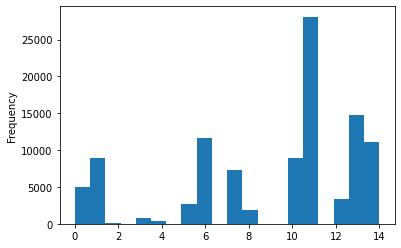

In [8]:
prediction_df.predicted_topic.plot(kind='hist', bins=20);

In [9]:
prediction_df[prediction_df.predicted_topic == 4]

,id,stemmed_words,tf,topicDistribution,predicted_topic
314,516,"[вид, потенциа, пенсион, накоплен, стран, заяв...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, ...","[0.0008469514764939144, 0.0008762219063537814,...",4
505,836,"[рад, министерств, финанс, представ, нов, сист...","(0.0, 1.0, 0.0, 0.0, 0.0, 4.0, 1.0, 0.0, 0.0, ...","[0.00045827041505580406, 0.0004741080424840586...",4
745,1232,"[разработа, страхован, жизн, тех, страхован, д...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0012711222821679764, 0.0013150520058779972,...",4
1747,2870,"[соч, развива, параллельн, минфин, нов, систем...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0008023291064739713, 0.0008300571886347148,...",4
1966,3198,"[министерств, финанс, сообщ, дета, законопроек...","(1.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 1.0, ...","[0.0005644287586321742, 0.0005839353731964177,...",4
...,...,...,...,...,...
103099,175400,"[вариант, стратег, пенсион, реформ, направл, т...","(2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0004688520877802065, 0.0004850555027127586,...",4
103740,176287,"[поддержива, инициатив, част, пенс, основ, пре...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.00089682985884966, 0.0009278241349495869, 0...",4
103859,176425,"[россиян, переход, сист, пенсион, накоплен, по...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0005697074471090656, 0.000589396457874086, ...",4
104093,176807,"[долгосрочн, прогноз, предполага, проведен, пе...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0009240387345465819, 0.0009559734241749246,...",4


In [10]:
inflation_df = pd.read_csv('data/russian_frame.csv')[['id', 'text']]
inflation_df

,id,text
0,1,"МОСКВА, 17 ноября/ Радио Sputnik. Белоруссия р..."
1,3,"ДУБАЙ, 17 ноя - РИА Новости. Министр промышлен..."
2,4,"МИНСК, 17 ноя - РИА Новости. Белоруссия рассчи..."
3,5,"МИНСК, 17 ноя — РИА Новости. Напряженные отнош..."
4,6,"МОСКВА, 17 ноя — РИА Новости. Эксперт по финан..."
...,...,...
104842,181653,"Премьер-министр РФ Дмитрий Медведев считает, ч..."
104843,181765,Госдума ратифицировала протокол о присоединени...
104844,182043,На встрече Путина и Титова речь шла о внесении...
104845,182433,Президент РФ Владимир Путин 28 июня представил...


In [11]:
def check_inflation(text):
    if 'рост цен' in text:
        return 1
    else:
        return 0
inflation_df['related'] = inflation_df.text.map(check_inflation)

In [12]:
inflation_df[inflation_df.related == 1]

,id,text,related
26,35,"МОСКВА, 15 ноя - РИА Новости. Федеральная анти...",1
117,171,"МОСКВА, 13 ноя - РИА Новости. Росстат продолжа...",1
172,261,"МОСКВА, 12 ноя - РИА Новости. Дефицита гречихи...",1
270,446,"МОСКВА, 7 ноя - РИА Новости. Укрепление рубля ...",1
272,450,"МОСКВА, 7 ноя - РИА Новости. Федеральная антим...",1
...,...,...,...
104405,177281,"\nБЛАГОВЕЩЕНСК, 30 окт - РИА Новости, Светлана...",1
104455,177373,"\nМОСКВА, 26 окт - РИА Новости. Индекс цен про...",1
104604,177612,"\nМОСКВА, 23 окт - РИА Новости. Государственны...",1
104653,177702,"\nМОСКВА, 19 окт - РИА Новости. Стоимость прое...",1


In [31]:
prediction_df[prediction_df.id == 177373].topicDistribution.values

array([DenseVector([0.0006, 0.9083, 0.0006, 0.0006, 0.0006, 0.0006, 0.0007, 0.0006, 0.0006, 0.0006, 0.0836, 0.0008, 0.0006, 0.0007, 0.0007])],
      dtype=object)

In [14]:
test = inflation_df.merge(prediction_df[['id', 'predicted_topic']], on='id', how='left')

In [15]:
test[test.related == 1].predicted_topic.value_counts()

10    340
1     275
11    171
14    134
13     98
0      61
12     61
7      51
6      26
3       9
5       3
8       2
4       1
Name: predicted_topic, dtype: int64

In [32]:
test[test.predicted_topic == 1].iloc[:10]

,id,text,related,predicted_topic
20,25,"МОСКВА, 15 ноя — РИА Новости. ""Газпром экспорт...",0,1
21,27,"Польша ""прекрасно"" обойдется без российского г...",0,1
37,50,"ВАРШАВА, 15 ноя — РИА Новости. Польша уверена,...",0,1
57,76,"МОСКВА, 15 ноя - РИА Новости. Минэнерго РФ ожи...",0,1
78,119,"МОСКВА, 14 ноя — РИА Новости. Стоимость нового...",0,1
111,164,"МОСКВА, 13 ноя - РИА Новости. Российский эколо...",0,1
134,203,"ЮЖНО-САХАЛИНСК, 13 ноя – РИА Новости. Резидент...",0,1
151,226,"МОСКВА, 12 ноя - РИА Новости. Независимые росс...",0,1
171,260,"МОСКВА, 12 ноября/ Радио Sputnik. Торжественна...",0,1
174,263,"ПЕКИН, 12 ноя – РИА Новости. Официальный предс...",0,1


In [33]:
test[test.id == 119].text.values

array(['МОСКВА, 14 ноя — РИА Новости. Стоимость нового легкого самолета на замену кукурузника Ан-2 не должна превышать 120 миллионов рублей, а цена за час эксплуатации не должна быть больше 30 тысяч рублей, сообщает в четверг "Уральский завод гражданской авиации" (УЗГА).Конкурс на разработку этого самолета выиграла компания "Байкал-Инжиниринг", которая входит в состав УЗГА."Целевая стоимость самолета при серийном производстве не превышает 120 миллионов рублей в ценах 2020 года, а целевая себестоимость эксплуатации самолета в пересчете на летный час (без учета стоимости владения) — не более 30 тысяч рублей", — говорится в релизе.В пресс-службе рассказали, что Минпромторг задал требования, по многим параметрам превосходящие аналогичные характеристики Ан-2, а именно: расчетная крейсерская скорость полета — не менее 300 километров в час, расчетная практическая дальность полета с максимальной коммерческой нагрузкой — две тонны и с аварийным навигационным запасом на 45 минут полета — не мене

In [18]:
prediction_df[prediction_df.id == 35].stemmed_words.values

array([list(['федеральн', 'антимонопольн', 'фас', 'розничн', 'фас', 'андр', 'отвеч', 'соответств', 'указа', 'ведомств', 'вид', 'глобальн', 'пробл', 'дан', 'запас', 'плюс', 'урожа', 'полност', 'наш', 'потребн', 'никак', 'серьезн', 'пробл', 'должн', 'перв', 'втор', 'прежд', 'контрол', 'перв', 'плеч', 'производител', 'розниц', 'конкуренц', 'существ', 'люб', 'посмотрет', 'наскольк', 'замглав', 'фас', 'союз', 'предприят', 'рсмкп', 'опубликова', 'обращен', 'глав', 'фас', 'котор', 'происход', 'низк', 'текущ', 'антимонопольн', 'реш', 'провест', 'проверк', 'производител', 'фас', 'состоя', 'совещан', 'служб', 'представител', 'орган', 'управлен', 'апк', 'регион', 'ведомств', 'регион', 'основн', 'производител', 'культур', 'ситуац', 'наход', 'контрол', 'территориальн', 'дефицит', 'наблюда'])],
      dtype=object)